In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df = pd.read_csv('../data/steam.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [70]:
df.shape

(27075, 18)

In [71]:
# Convert owner range into numeric averages

def owners_to_num(x):
    low, high = x.split("-")
    return (int(low) + int(high)) / 2

df["owners_num"] = df["owners"].apply(owners_to_num)

In [72]:
# Drop unnecessary columns

df = df.drop(columns=['appid', 'release_date', 'developer', 'publisher', 'platforms', 'owners'], errors='ignore')

In [73]:
# Top 5 playtime

df['average_playtime'].sort_values(ascending=0).head(5)

9201    190625
1478     95245
6014     95242
8969     63481
3930     55204
Name: average_playtime, dtype: int64

In [74]:
# drop the outlier game

df = df.drop(df["average_playtime"].idxmax())

In [75]:
df['average_playtime'].max()

np.int64(95245)

In [76]:
df['average_playtime'].min()

np.int64(0)

In [77]:
# Show summary statistics and percentiles for 'average_playtime'

df['average_playtime'].describe(percentiles=[0.25, 0.5, 0.75,0.8, 0.85, 0.9, 0.99])

count    27074.000000
mean       142.769594
std       1413.517634
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
80%         17.000000
85%        137.000000
90%        244.000000
99%       2121.700000
max      95245.000000
Name: average_playtime, dtype: float64

In [78]:
bins = [0, 1, 10, 50, 200, df['average_playtime'].max() + 1]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Addictive']

df['playtime_group'] = pd.cut(df['average_playtime'], bins=bins, labels=labels, include_lowest=True)

print(df['playtime_group'].value_counts())

print("\nPercentage per group:")
print(df['playtime_group'].value_counts(normalize=True) * 100)

playtime_group
Very Short    21061
Addictive      3446
Long           1467
Medium          682
Short           418
Name: count, dtype: int64

Percentage per group:
playtime_group
Very Short    77.790500
Addictive     12.728079
Long           5.418483
Medium         2.519022
Short          1.543917
Name: proportion, dtype: float64


In [79]:
# Encode playtime groups into ordered numeric values

categories = [['Very Short', 'Short', 'Medium', 'Long', 'Addictive']]
encoder = OrdinalEncoder(categories=categories)
df['playtime_group_encoded'] = encoder.fit_transform(df[['playtime_group']]).astype(int)
df['playtime_group_encoded']

0        4
1        4
2        3
3        4
4        4
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: playtime_group_encoded, Length: 27074, dtype: int64

In [80]:
# Convert multi-value text columns into binary features using MultiLabelBinarizer

text_cols = ['categories', 'genres', 'steamspy_tags']
df_final = df.copy()

for col in text_cols:
    if col in df_final.columns:

        df_final[col] = df_final[col].fillna('').astype(str).str.split(';')
        mlb = MultiLabelBinarizer()

        encoded_cols = pd.DataFrame(
            mlb.fit_transform(df_final[col]),
            columns=[f"{col}_{c}" for c in mlb.classes_],
            index=df_final.index
        )
        df_final = pd.concat([df_final, encoded_cols], axis=1)
        df_final.drop(columns=[col], inplace=True)


In [81]:
# Define the list of numerical features to be used for modeling

numerical_features = [
    'required_age', 'achievements', 'positive_ratings', 'negative_ratings',
    'median_playtime', 'owners_num', 'price', 'playtime_group_encoded'
]


In [82]:
df_final.shape

(27074, 409)

# Linear Regression 

In [83]:
X = df_final[numerical_features].drop(columns=['average_playtime'], errors='ignore')
y = df_final['average_playtime']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [85]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [87]:
y_pred = linear_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_reg = linear_model.score(X_test, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2_reg:.4f}")

RMSE: 604.8485
R-squared: 0.8363


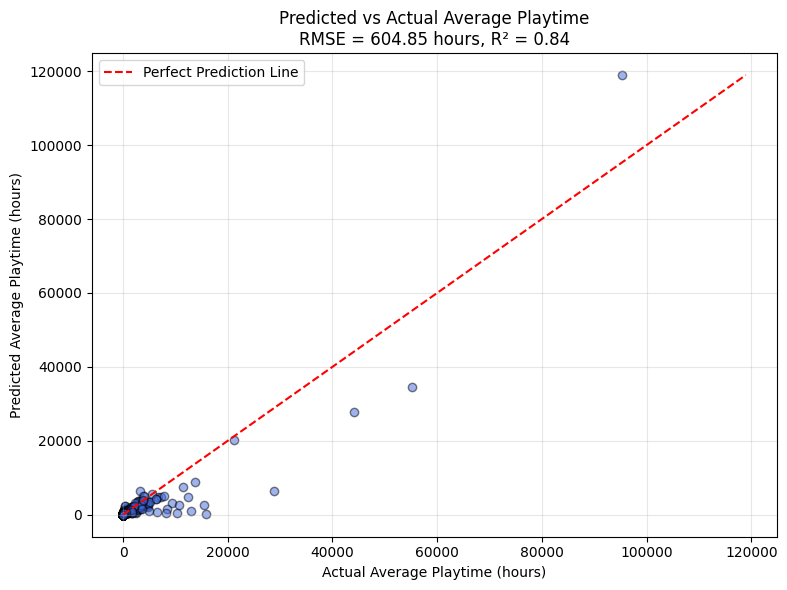

In [88]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue', edgecolor='k')

max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction Line')

plt.title(f'Predicted vs Actual Average Playtime\nRMSE = {rmse:.2f} hours, R² = {r2_reg:.2f}', fontsize=12)
plt.xlabel('Actual Average Playtime (hours)')
plt.ylabel('Predicted Average Playtime (hours)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Top 10 Most Important Features (Linear Regression):

                  Feature  Coefficient  |Coefficient|
7  playtime_group_encoded    55.574518      55.574518
6                   price     1.431016       1.431016
4         median_playtime     0.623407       0.623407
0            required_age     0.393117       0.393117
1            achievements     0.035888       0.035888
3        negative_ratings     0.010160       0.010160
2        positive_ratings     0.003289       0.003289
5              owners_num     0.000132       0.000132


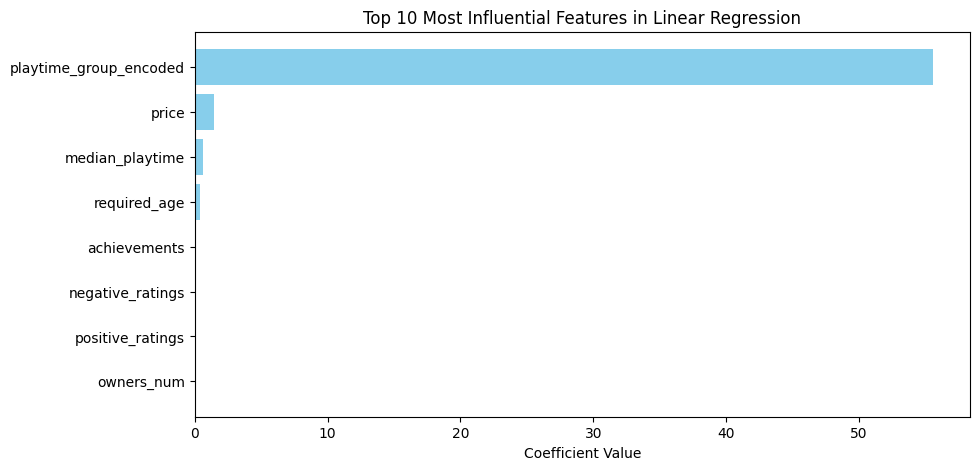

In [89]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_model.coef_
})

coef_df['|Coefficient|'] = coef_df['Coefficient'].abs()

coef_df = coef_df.sort_values(by='|Coefficient|', ascending=False)

print("Top 10 Most Important Features (Linear Regression):\n")
print(coef_df.head(10))

plt.figure(figsize=(10, 5))
plt.barh(coef_df['Feature'].head(10), coef_df['Coefficient'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Most Influential Features in Linear Regression')
plt.xlabel('Coefficient Value')
plt.show()


# Decision Tree Classifier 

In [90]:
playtime_original = df_final['average_playtime']
addictive_threshold = playtime_original.quantile(0.90)
addictive_threshold

np.float64(244.0)

In [91]:
df_final['is_addictive'] = (playtime_original > addictive_threshold).astype(int)

In [92]:
X = df_final.drop(columns=['average_playtime', 'is_addictive', 'median_playtime', 'english', 'price', 'required_age', 'playtime_group','name'], errors='ignore')
y = df_final['is_addictive']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [95]:
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"(Accuracy): {accuracy:.4f}")

(Accuracy): 0.9692


In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7304
           1       0.80      0.93      0.86       819

    accuracy                           0.97      8123
   macro avg       0.90      0.95      0.92      8123
weighted avg       0.97      0.97      0.97      8123



In [97]:
playtime_original = df_final['average_playtime']
addictive_threshold = playtime_original.quantile(0.90)
print("Addictive threshold (average_playtime):", addictive_threshold)


Addictive threshold (average_playtime): 244.0


In [98]:

addictive_games_df = df_final[df_final['is_addictive'] == 1][['name', 'average_playtime', 'is_addictive']]

addictive_games_df.head(80)


,name,average_playtime,is_addictive
0,Counter-Strike,17612,1
1,Team Fortress Classic,277,1
3,Deathmatch Classic,258,1
4,Half-Life: Opposing Force,624,1
6,Half-Life,1300,1
...,...,...,...
215,EVE Online,5123,1
216,RACE 07,1636,1
219,BioShock Infinite,614,1
222,Sid Meier's Civilization® V,4760,1


In [99]:
addictive_games_df.shape


(2698, 3)

                                   Feature  Importance
4                   playtime_group_encoded    0.897497
1                         positive_ratings    0.029478
3                               owners_num    0.011260
2                         negative_ratings    0.010327
0                             achievements    0.009300
47                            genres_Indie    0.003229
21   categories_Partial Controller Support    0.003197
112                   steamspy_tags_Casual    0.003104
36                        genres_Adventure    0.002544
285                   steamspy_tags_Puzzle    0.002355


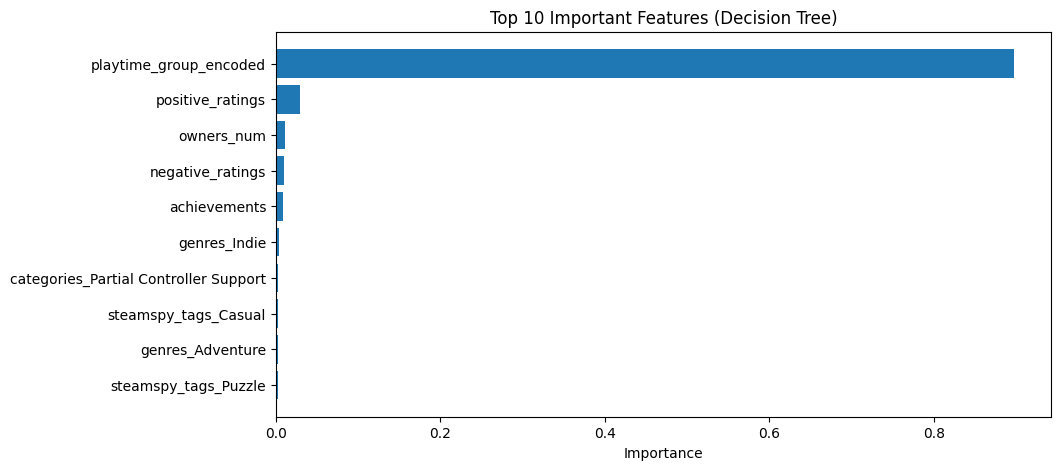

In [100]:
feature_names = X_train.columns

importances = dt_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10,5))
plt.barh(feat_imp['Feature'].head(10), feat_imp['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features (Decision Tree)')
plt.xlabel('Importance')
plt.show()

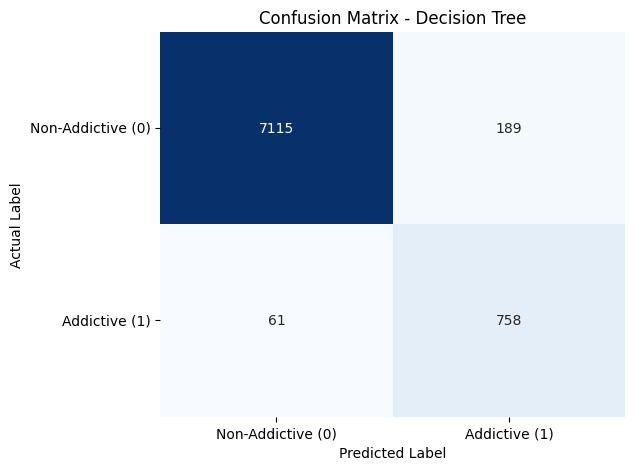

In [101]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks([0.5, 1.5], ['Non-Addictive (0)', 'Addictive (1)'])
plt.yticks([0.5, 1.5], ['Non-Addictive (0)', 'Addictive (1)'], rotation=0)
plt.show()


In [102]:
df_copy = df.copy()
addictive_threshold = df_final['average_playtime'].quantile(0.90)
df_copy['is_addictive'] = (df_final['average_playtime'] > addictive_threshold).astype(int)
df_copy.head()


,name,english,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_num,playtime_group,playtime_group_encoded,is_addictive
0,Counter-Strike,1,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,7.19,15000000.0,Addictive,4,1
1,Team Fortress Classic,1,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,3.99,7500000.0,Addictive,4,1
2,Day of Defeat,1,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,3.99,7500000.0,Long,3,0
3,Deathmatch Classic,1,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,3.99,7500000.0,Addictive,4,1
4,Half-Life: Opposing Force,1,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,3.99,7500000.0,Addictive,4,1


# XGBoost Classifier

In [103]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier(
    random_state=42,  
    n_estimators=150, 
    learning_rate=0.1 
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9718084451557306


<Figure size 1000x600 with 0 Axes>

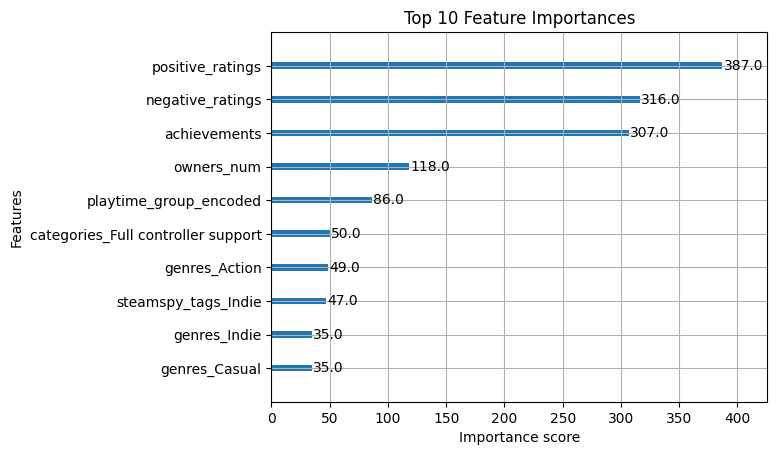

In [104]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importances")
plt.show()


# Random Forest Regression


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,    
    random_state=42,
    n_jobs=-1         
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest RMSE: 0.15
Random Forest R²: 0.76


In [106]:
feature_importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features (Random Forest):")
print(feat_imp.head(10))

Top 10 Important Features (Random Forest):
                                   Feature  Importance
4                   playtime_group_encoded    0.762850
1                         positive_ratings    0.047728
2                         negative_ratings    0.029072
0                             achievements    0.020246
3                               owners_num    0.014084
202                    steamspy_tags_Indie    0.004248
285                   steamspy_tags_Puzzle    0.003580
21   categories_Partial Controller Support    0.003408
26                  categories_Steam Cloud    0.003192
79                 steamspy_tags_Adventure    0.003156


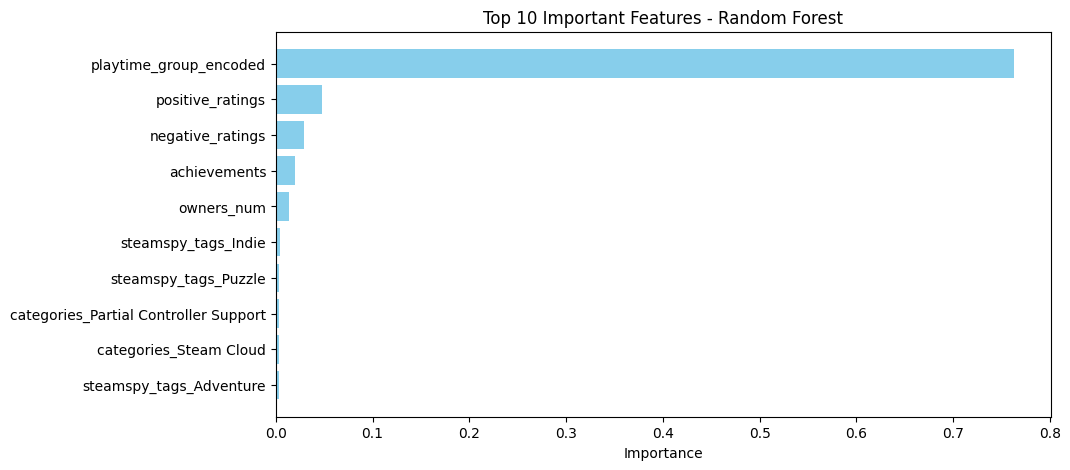

In [107]:
plt.figure(figsize=(10,5))
plt.barh(feat_imp['Feature'].head(10), feat_imp['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features - Random Forest')
plt.xlabel('Importance')
plt.show()



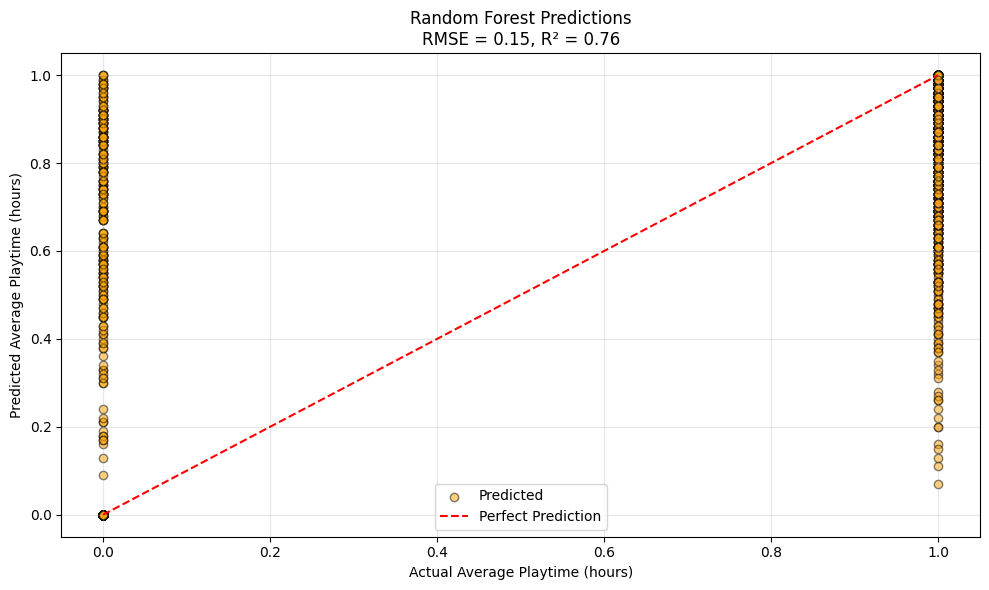

In [108]:
plt.figure(figsize=(10,6))

plt.scatter(y_test, y_pred_rf, alpha=0.5, color='orange', edgecolor='k', label='Predicted')

max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Average Playtime (hours)')
plt.ylabel('Predicted Average Playtime (hours)')
plt.title(f'Random Forest Predictions\nRMSE = {rmse_rf:.2f}, R² = {r2_rf:.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Gradient Boosting Regression

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_final[numerical_features].drop(columns=['average_playtime'], errors='ignore')
y = df_final['average_playtime']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

gb_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting → RMSE: {rmse_gb:.2f}, R²: {r2_gb:.2f}")


Gradient Boosting → RMSE: 508.26, R²: 0.88


In [110]:
feature_importances = gb_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X_train.columns,   
    'Importance': feature_importances
})

feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

print("Top 10 Important Features (Gradient Boosting):")
print(feat_imp.head(10))

Top 10 Important Features (Gradient Boosting):
                  Feature  Importance
4         median_playtime    0.876081
2        positive_ratings    0.048978
5              owners_num    0.024262
3        negative_ratings    0.018064
1            achievements    0.016821
7  playtime_group_encoded    0.011878
6                   price    0.003646
0            required_age    0.000271


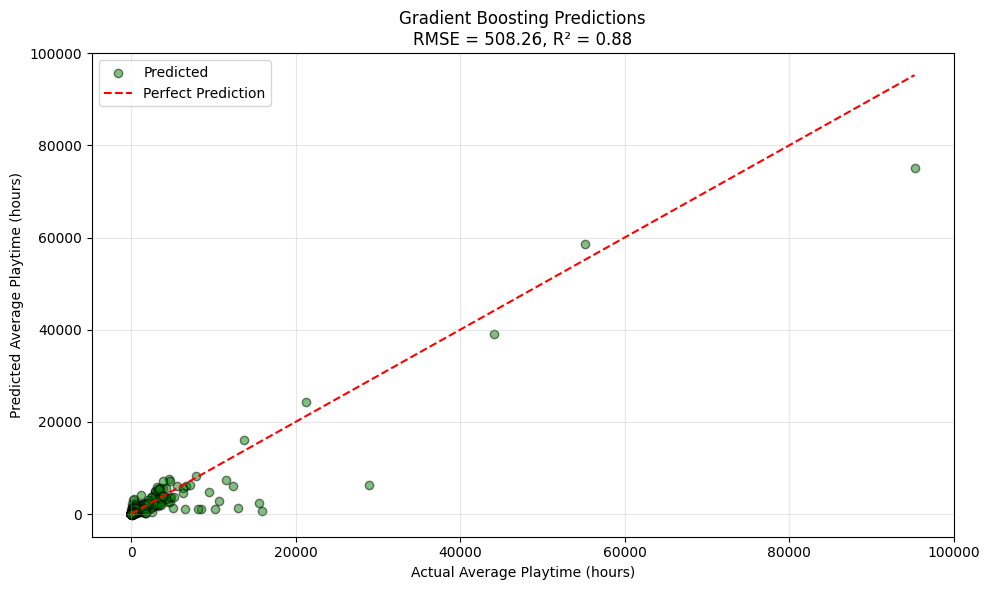

In [111]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='green', edgecolor='k', label='Predicted')
max_val = max(y_test.max(), y_pred_gb.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Average Playtime (hours)')
plt.ylabel('Predicted Average Playtime (hours)')
plt.title(f'Gradient Boosting Predictions\nRMSE = {rmse_gb:.2f}, R² = {r2_gb:.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

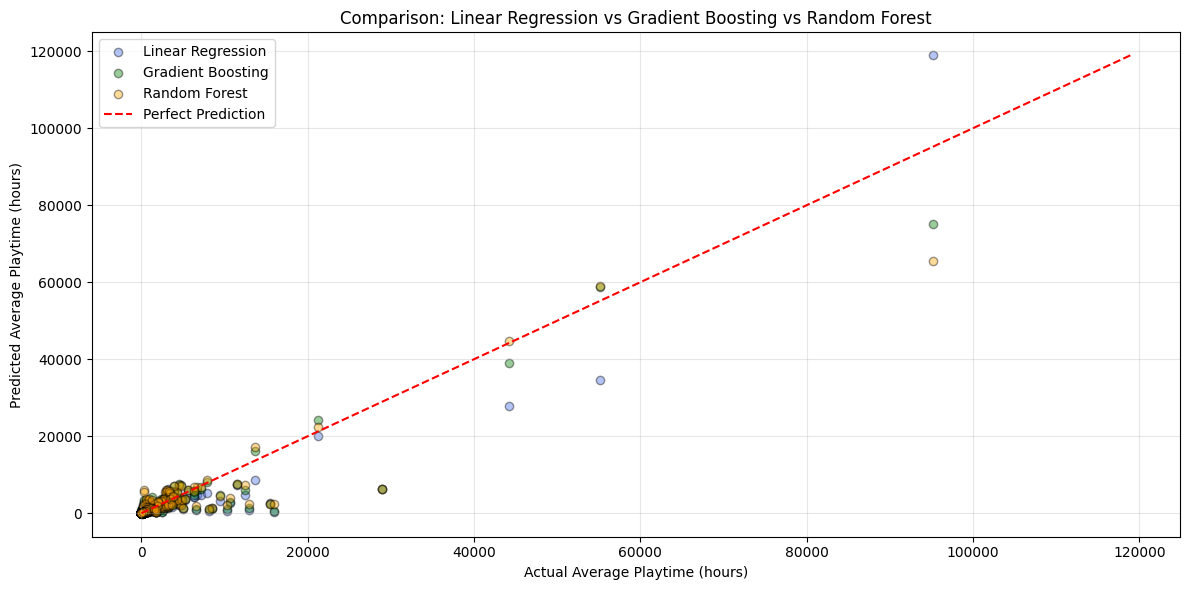

=== Model Performance Comparison ===

1️⃣ Linear Regression:
   RMSE     : 604.8485
   R-squared: 0.8363

2️⃣ Gradient Boosting:
   RMSE     : 508.26
   R-squared: 0.88

3️⃣ Random Forest:
   RMSE     : 552.93
   R-squared: 0.86


In [112]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_lr = linear_model.predict(X_test_scaled)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)


from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_reg = r2_score(y_test, y_pred_lr)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_lr, alpha=0.4, label='Linear Regression', color='royalblue', edgecolor='k')
plt.scatter(y_test, y_pred_gb, alpha=0.4, label='Gradient Boosting', color='green', edgecolor='k')
plt.scatter(y_test, y_pred_rf, alpha=0.4, label='Random Forest', color='orange', edgecolor='k')

max_val = max(y_test.max(), y_pred_lr.max(), y_pred_gb.max(), y_pred_rf.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Average Playtime (hours)')
plt.ylabel('Predicted Average Playtime (hours)')
plt.title('Comparison: Linear Regression vs Gradient Boosting vs Random Forest')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("=== Model Performance Comparison ===\n")
print("1️⃣ Linear Regression:")
print(f"   RMSE     : {rmse:.4f}")
print(f"   R-squared: {r2_reg:.4f}\n")

print("2️⃣ Gradient Boosting:")
print(f"   RMSE     : {rmse_gb:.2f}")
print(f"   R-squared: {r2_gb:.2f}\n")

print("3️⃣ Random Forest:")
print(f"   RMSE     : {rmse_rf:.2f}")
print(f"   R-squared: {r2_rf:.2f}")


In [113]:
playtime_original = df_final['average_playtime']
addictive_threshold = playtime_original.quantile(0.90)
df_final['is_addictive'] = (playtime_original > addictive_threshold).astype(int)


In [114]:
X = df_final.drop(columns=['average_playtime', 'is_addictive', 'median_playtime', 'english', 'price', 'required_age', 'playtime_group','name'], errors='ignore')
y = df_final['is_addictive']


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [116]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)


In [117]:
accuracy = accuracy_score(y_test, y_pred)
print(f"(Accuracy): {accuracy:.4f}")

print(classification_report(y_test, y_pred))


(Accuracy): 0.9692
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7304
           1       0.80      0.93      0.86       819

    accuracy                           0.97      8123
   macro avg       0.90      0.95      0.92      8123
weighted avg       0.97      0.97      0.97      8123

